In [1]:
!pip install -q transformers datasets peft accelerate scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import torch
import numpy as np
import pandas as pd
import pickle
from datasets import load_dataset, Dataset
from torch.utils.data import DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [3]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Load AG News dataset
print("Loading AG News dataset...")
dataset = load_dataset("ag_news")

Loading AG News dataset...


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [5]:
# Split training set to create validation set
train_val = dataset["train"].train_test_split(test_size=0.1, seed=seed)
dataset_dict = {
    "train": train_val["train"],
    "validation": train_val["test"],
    "test": dataset["test"]
}

print(f"Train set size: {len(dataset_dict['train'])}")
print(f"Validation set size: {len(dataset_dict['validation'])}")
print(f"Test set size: {len(dataset_dict['test'])}")

Train set size: 108000
Validation set size: 12000
Test set size: 7600


In [6]:
# Load tokenizer and process dataset
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

tokenized_dataset = {}
for split in dataset_dict:
    tokenized_dataset[split] = dataset_dict[split].map(
        tokenize_function,
        batched=True,
        remove_columns=["text"]
    )
    tokenized_dataset[split] = tokenized_dataset[split].rename_column("label", "labels")
    tokenized_dataset[split].set_format("torch", columns=["input_ids", "attention_mask", "labels"])


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/108000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [7]:
# Load pre-trained model and apply LoRA
print("Loading RoBERTa model...")
model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=4
)

# Define target modules for RoBERTa
target_modules = [
    "query", "value", "linear", "word_embeddings", "position_embeddings"
]

# Define LoRA configuration
lora_config = LoraConfig(
    r=4,                      # Rank of the update matrices
    lora_alpha=16,            # Scaling factor
    target_modules=target_modules,
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS
)

# Apply LoRA to model
print("Applying LoRA to model...")
model = get_peft_model(model, lora_config)
model.to(device)

# Print trainable parameters
model.print_trainable_parameters()


Loading RoBERTa model...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Applying LoRA to model...
trainable params: 950,384 || all params: 125,599,092 || trainable%: 0.7567


In [8]:
# Define evaluation metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted'
    )

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [9]:
# Configure Trainer arguments
training_args = TrainingArguments(
    output_dir="./ag_news_roberta_lora",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=128,
    num_train_epochs=3,
    weight_decay=0.01,
    warmup_steps=500,
    logging_dir="./logs",
    logging_steps=100,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2,
)

trainer_kwargs = {
    "model": model,
    "args": training_args,
    "train_dataset": tokenized_dataset["train"],
    "eval_dataset": tokenized_dataset["validation"],
    "compute_metrics": compute_metrics,
}

In [10]:
trainer = Trainer(**trainer_kwargs)

trainer.train()

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.237400,0.216217,0.926583,0.926726,0.926583,0.926473
2,0.167600,0.185644,0.937833,0.938124,0.937833,0.937828
3,0.142600,0.194097,0.936417,0.936710,0.936417,0.936413


TrainOutput(global_step=5064, training_loss=0.2362346447662908, metrics={'train_runtime': 1115.6065, 'train_samples_per_second': 290.425, 'train_steps_per_second': 4.539, 'total_flos': 2.1548864139264e+16, 'train_loss': 0.2362346447662908, 'epoch': 3.0})

In [11]:
# Evaluate model on test set
print("Evaluating model on test set...")
eval_results = trainer.evaluate(tokenized_dataset["test"])
print("Test Evaluation Results:", eval_results)

Evaluating model on test set...


Test Evaluation Results: {'eval_loss': 0.19023354351520538, 'eval_accuracy': 0.9353947368421053, 'eval_precision': 0.9354528299769386, 'eval_recall': 0.9353947368421053, 'eval_f1': 0.9353353909093213, 'eval_runtime': 10.8409, 'eval_samples_per_second': 701.05, 'eval_steps_per_second': 5.535, 'epoch': 3.0}


In [12]:
# Save the fine-tuned model
model.save_pretrained("./final_model")
tokenizer.save_pretrained("./final_model")
print("Model and tokenizer saved to ./final_model")

Model and tokenizer saved to ./final_model


In [13]:
# Calculate training parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {trainable_params} ({100 * trainable_params/total_params:.2f}% of total)")
print(f"Total parameters: {total_params}")

Trainable parameters: 950384 (0.76% of total)
Total parameters: 125599092


In [28]:
# Evaluate model on test set
eval_results = trainer.evaluate(tokenized_dataset["test"])

# Extract accuracy (Trainer prefixes metrics with "eval_")
test_accuracy = eval_results.get("eval_accuracy", eval_results.get("accuracy"))

# Print in percent form
print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")


Final Test Accuracy: 93.54%


In [23]:
import matplotlib.pyplot as plt

history = trainer.state.log_history
# Prepare lists
epochs = []
train_losses = []
val_losses = []
val_accuracies = []
seen_epochs = set()

for record in history:
    if 'loss' in record and 'eval_loss' not in record:
        epoch = record.get('epoch')
        if epoch and epoch not in seen_epochs:
            train_losses.append(record['loss'])
            # Only append to epochs for training loss records
            epochs.append(epoch)
            seen_epochs.add(epoch)
    if 'eval_loss' in record:
        val_losses.append(record['eval_loss'])
    if 'eval_accuracy' in record:
        val_accuracies.append(record['eval_accuracy'])

# Create a list of epoch numbers for evaluation metrics
eval_epochs = list(range(1, len(val_losses) + 1)) # Assumes evaluation at end of each epoch


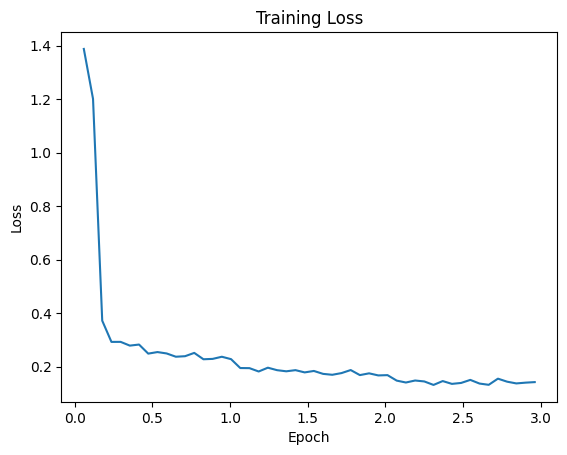

In [15]:
# Plot Training Loss
plt.figure()
plt.plot(epochs, train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

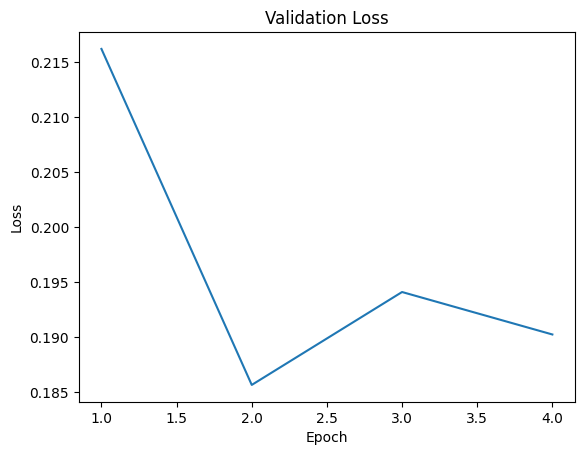

In [24]:
# Plot Validation Loss
plt.figure()
plt.plot(eval_epochs, val_losses) # Use eval_epochs for x-axis
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


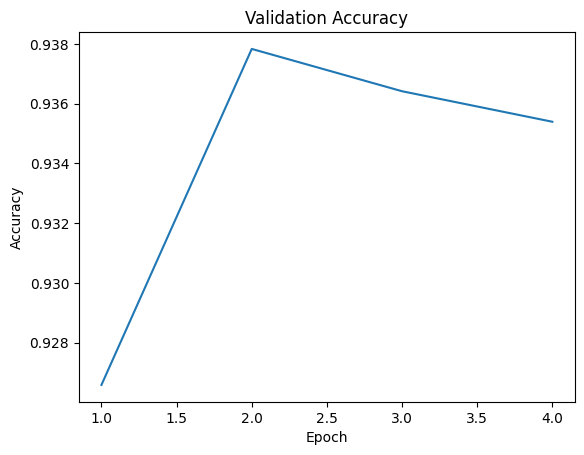

In [25]:
# Plot Validation Accuracy
plt.figure()
plt.plot(eval_epochs, val_accuracies) # Use eval_epochs for x-axis
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [26]:
from google.colab import files
uploaded = files.upload()

Saving test_unlabelled.pkl to test_unlabelled.pkl


In [29]:
# Load unlabelled test data and make predictions
try:
    print("Loading unlabelled test data...")
    with open("test_unlabelled.pkl", "rb") as f:
        test_dataset = pickle.load(f)

    # Convert to HuggingFace Dataset format
    test_dataset = Dataset.from_dict({"text": test_dataset["text"]})

    # Tokenize test data
    tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)
    tokenized_test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])
    test_dataloader = DataLoader(tokenized_test_dataset, batch_size=64)

    # Generate predictions
    print("Generating predictions...")
    model.eval()
    all_predictions = []

    with torch.no_grad():
        for batch in test_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            preds = torch.argmax(outputs.logits, dim=-1)
            all_predictions.extend(preds.cpu().numpy())

    # Save predictions to CSV
    df = pd.DataFrame({
        "ID": list(range(len(all_predictions))),
        "label": all_predictions
    })
    df.to_csv("submission.csv", index=False)
    print("Predictions saved to submission.csv")

except FileNotFoundError:
    print("test_unlabelled.pkl file not found.")
except Exception as e:
    print(f"Error during prediction generation: {str(e)}")

Loading unlabelled test data...


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Generating predictions...
Predictions saved to submission.csv
